In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [3]:
def detect_outliers(df, n, features):
    outlier_indices=[]
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)
        
    return multiple_outliers
    
Outliers_to_drop = detect_outliers(train, 2,['Age', 'SibSp', 'Parch', 'Fare'])


In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [6]:
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

In [7]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


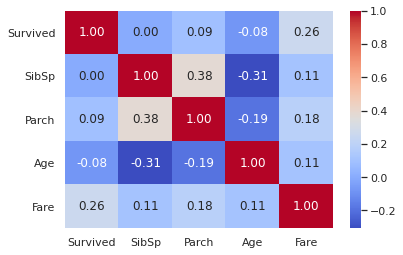

In [9]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt=".2f", cmap = 'coolwarm')

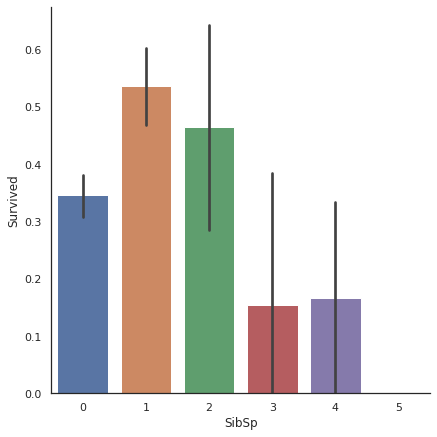

In [10]:
f = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6)


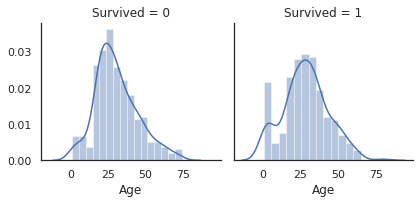

In [11]:
f = sns.FacetGrid(train, col = 'Survived')
f = f.map(sns.distplot, 'Age')

<AxesSubplot:xlabel='Age', ylabel='Density'>

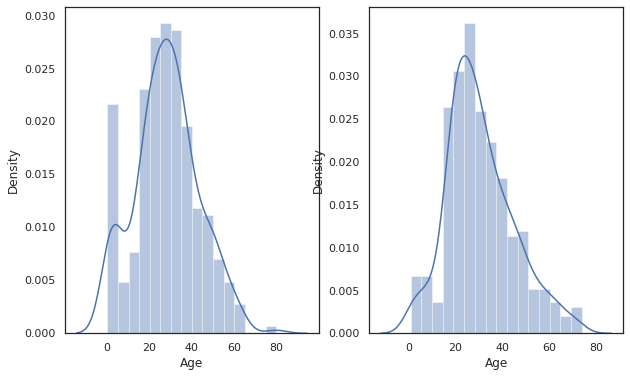

In [12]:
f, ax = plt.subplots(1,2,figsize=(10,6))
sns.distplot(train[train['Survived']==1]['Age'], ax=ax[0])
sns.distplot(train[train['Survived']==0]['Age'], ax=ax[1])

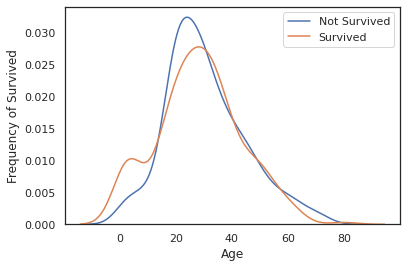

In [13]:
f = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())])
f = sns.kdeplot(train['Age'][(train['Survived']==1) &(train['Age'].notnull())])
f.set_xlabel('Age')
f.set_ylabel('Frequency of Survived')
f.legend(['Not Survived', 'Survived'])

In [14]:
dataset.loc[dataset['Fare'].isnull()] = dataset['Fare'].median()

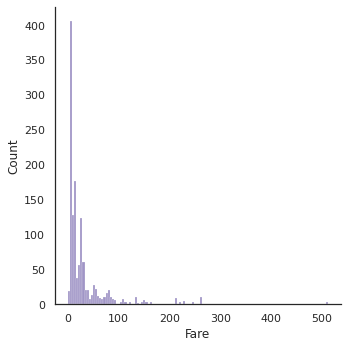

In [15]:
f = sns.displot(dataset['Fare'], color='m', label ='Skewness : %.2f'%(dataset['Fare'].skew()))


In [16]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

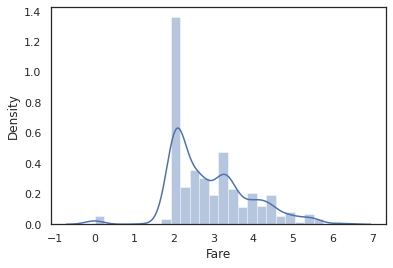

In [17]:
f = sns.distplot(dataset['Fare'])

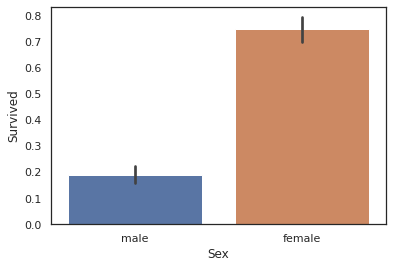

In [18]:
f = sns.barplot('Sex', 'Survived', data= train)

In [19]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


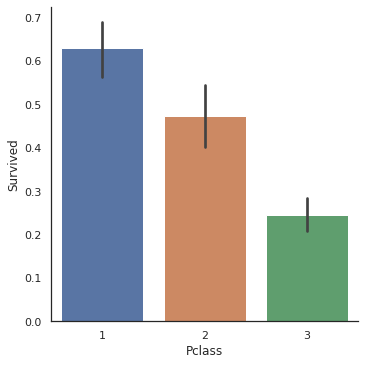

In [20]:
f = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar')

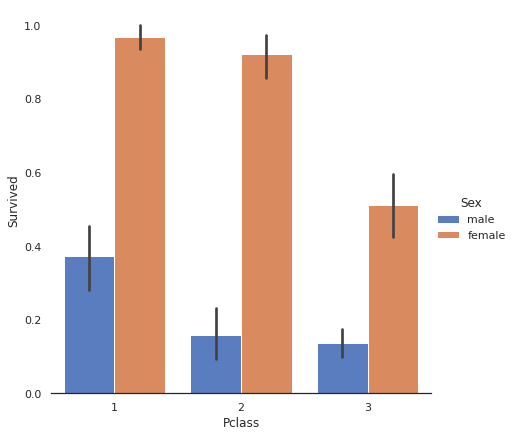

In [21]:
f = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar',palette = 'muted')
f.despine(left=True)

In [22]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

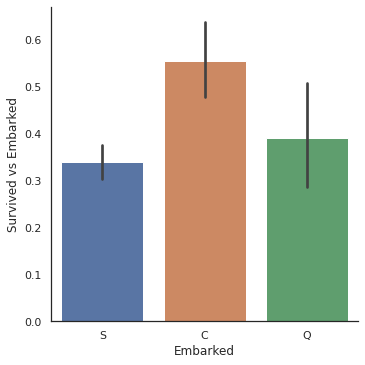

In [23]:
f = sns.factorplot(x = 'Embarked',y='Survived', data = train, kind = 'bar')
f = f.set_ylabels('Survived vs Embarked')

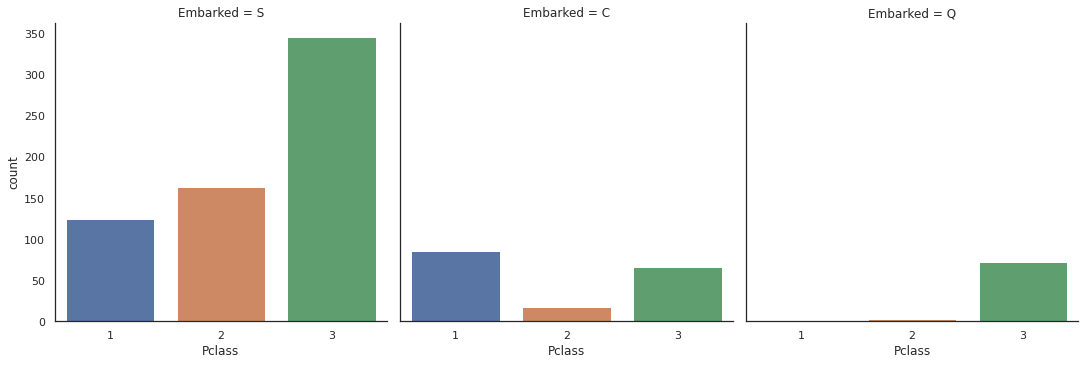

In [24]:
f = sns.factorplot('Pclass', col='Embarked', data=train, kind='count')

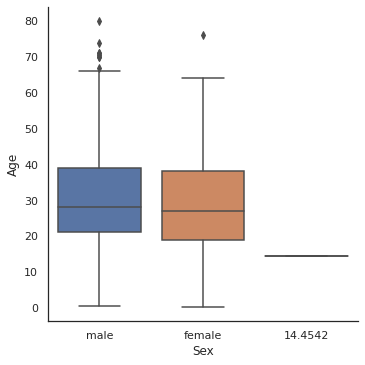

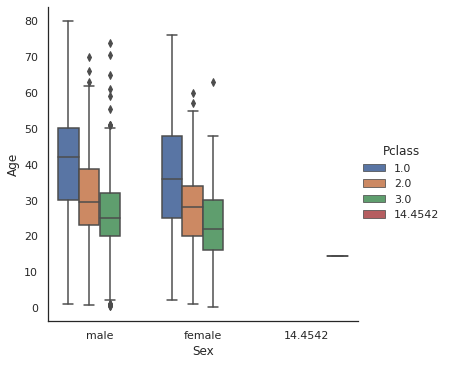

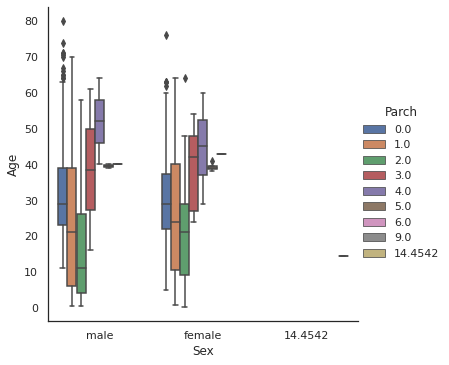

In [25]:
f = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
f = sns.factorplot(y= 'Age', x='Sex', hue='Pclass', data=dataset, kind='box')
f = sns.factorplot(x='Sex', y='Age', hue = 'Parch', data=dataset, kind='box')

In [26]:
dataset['Sex'] = dataset['Sex'].map({'male' :0 , 'female' : 1})

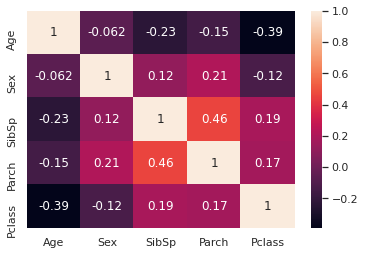

In [27]:
f = sns.heatmap(dataset[['Age', 'Sex','SibSp', 'Parch', 'Pclass']].corr(), annot=True)

In [28]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

In [29]:
for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) 
                               & (dataset['Parch'] == dataset.iloc[i]['Parch'])
                              & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

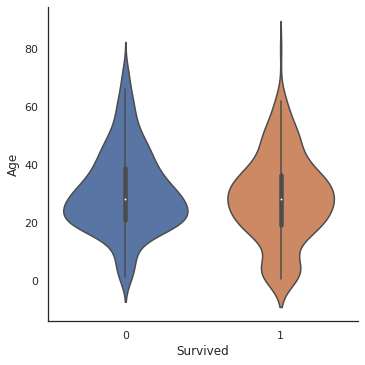

In [30]:
f = sns.factorplot(x='Survived', y='Age', data=train, kind = 'violin')

In [31]:
dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.')

In [32]:
dataset['Title'].value_counts()

Mr          752
Miss        255
Mrs         197
Master       60
Rev           8
Dr            8
Col           4
Ms            2
Major         2
Mlle          2
Mme           1
Sir           1
Jonkheer      1
Lady          1
Countess      1
Capt          1
Dona          1
Don           1
Name: Title, dtype: int64

In [33]:
dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace = True)
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Ms':1, 'Mlle':1,'Mrs':1, 'Mr':2, 'Rare':3})

In [34]:
dataset['Title'].value_counts()

2.0    752
1.0    456
0.0     60
3.0     29
Name: Title, dtype: int64

In [35]:
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

In [36]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] +1

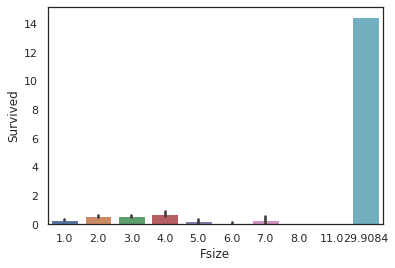

In [37]:
f = sns.barplot(x ='Fsize',y = 'Survived', data = dataset)

In [38]:
dataset['Single'] = dataset['Fsize'].map(lambda s:1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<= s <=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s>=5 else 0)


In [39]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF
0,1.0,0.0,3.0,0.0,22.0,1.0,0.0,A/5 21171,1.981001,NaN,S,2.0,2.0,0,1,0,0
1,2.0,1.0,1.0,1.0,38.0,1.0,0.0,PC 17599,4.266662,C85,C,1.0,2.0,0,1,0,0
2,3.0,1.0,3.0,1.0,26.0,0.0,0.0,STON/O2. 3101282,2.070022,NaN,S,1.0,1.0,1,0,0,0
3,4.0,1.0,1.0,1.0,35.0,1.0,0.0,113803,3.972177,C123,S,1.0,2.0,0,1,0,0
4,5.0,0.0,3.0,0.0,35.0,0.0,0.0,373450,2.085672,NaN,S,2.0,1.0,1,0,0,0


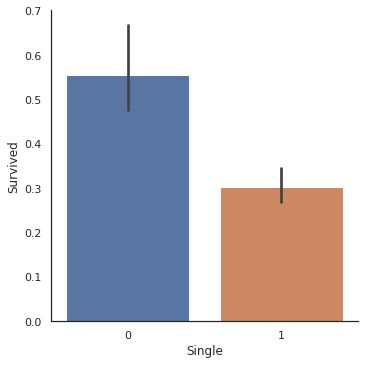

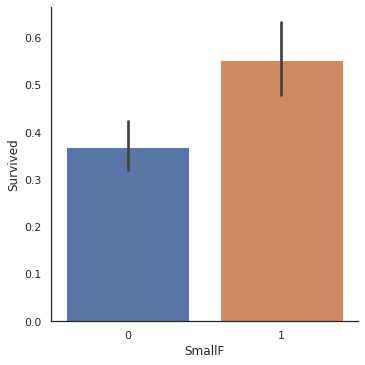

In [40]:
f = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
f = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')

In [41]:
dataset = pd.get_dummies(dataset, columns=['Title']) #성별
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Embark')

In [42]:
Ticket = []
for i in list(dataset.Ticket):
    if not str(i).isdigit() :
        Ticket.append(str(i).replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

In [43]:
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [44]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix = 'Tkt')

In [45]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset['Pclass'] = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [46]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [47]:
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Fsize,Single,...,Tkt_SOTONO2,Tkt_SOTONOQ,Tkt_SP,Tkt_STONO,Tkt_STONO2,Tkt_STONOQ,Tkt_SWPP,Tkt_WC,Tkt_WEP,Tkt_X
0,0.0,1.0,0.0,22.0,1.0,0.0,1.981001,NaN,2.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.0,1.0,38.0,1.0,0.0,4.266662,C85,2.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,3.0,1.0,26.0,0.0,0.0,2.070022,NaN,1.0,1,...,0,0,0,0,1,0,0,0,0,0
3,1.0,4.0,1.0,35.0,1.0,0.0,3.972177,C123,2.0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,5.0,0.0,35.0,0.0,0.0,2.085672,NaN,1.0,1,...,0,0,0,0,0,0,0,0,0,1


In [48]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

In [49]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis = 1)

In [50]:
kfold = StratifiedKFold(n_splits= 10)

In [51]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))

In [52]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y =Y_train, scoring = 'accuracy', cv=kfold, n_jobs =4))

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC"]})


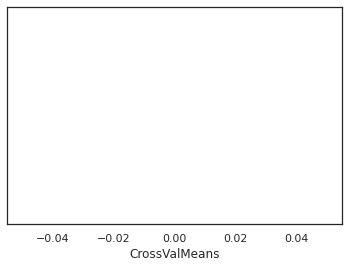

In [53]:
f = sns.barplot('CrossValMeans', data = cv_res)